In [1]:
# Transformers installation
! pip install -q transformers datasets evaluate
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.0 MB/s eta 0:00:00


# Semantic segmentation

In [2]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/dKE8SIt9C-w?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.9/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Semantic segmentation assigns a label or class to each individual pixel of an image. There are several types of segmentation, and in the case of semantic segmentation, no distinction is made between unique instances of the same object. Both objects are given the same label (for example, "car" instead of "car-1" and "car-2"). Common real-world applications of semantic segmentation include training self-driving cars to identify pedestrians and important traffic information, identifying cells and abnormalities in medical imagery, and monitoring environmental changes from satellite imagery.

This guide will show you how to:

1. Finetune [SegFormer](https://huggingface.co/docs/transformers/main/en/model_doc/segformer#segformer) on the [SceneParse150](https://huggingface.co/datasets/scene_parse_150) dataset.
2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[BEiT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/beit), [Data2VecVision](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/data2vec-vision), [DPT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/dpt), [MobileNetV2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilenet_v2), [MobileViT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilevit), [SegFormer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/segformer), [UPerNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/upernet)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers evaluate
```

We encourage you to log in to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to log in:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load SceneParse150 dataset

Start by loading a smaller subset of the SceneParse150 dataset from the 🤗 Datasets library. This'll give you a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [4]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:50]")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /root/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


Split the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [5]:
ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [6]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=683x512 at 0x7F78251C0970>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=683x512 at 0x7F77EFBAA370>,
 'scene_category': 927}

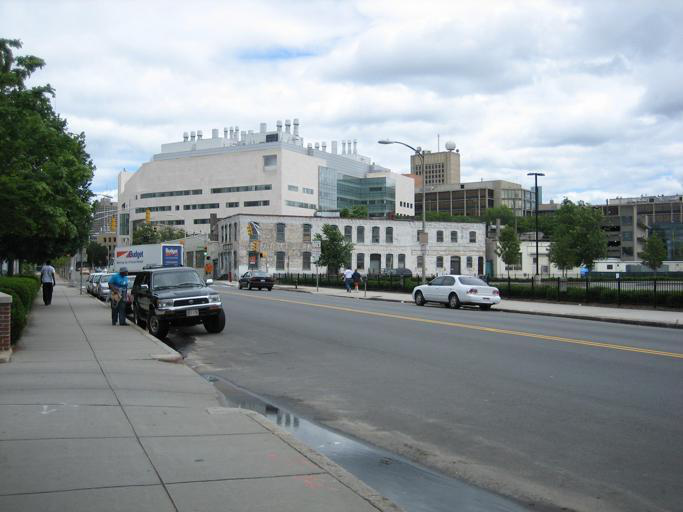

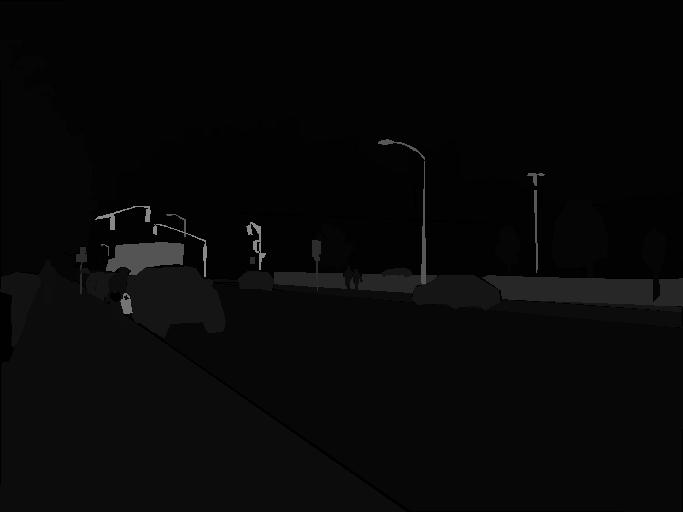

In [7]:
idx = 0
display(train_ds[idx]['image'])
display(train_ds[idx]['annotation'])

- `image`: a PIL image of the scene.
- `annotation`: a PIL image of the segmentation map, which is also the model's target.
- `scene_category`: a category id that describes the image scene like "kitchen" or "office". In this guide, you'll only need `image` and `annotation`, both of which are PIL images.

You'll also want to create a dictionary that maps a label id to a label class which will be useful when you set up the model later. Download the mappings from the Hub and create the `id2label` and `label2id` dictionaries:

In [8]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:637: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


## Preprocess

The next step is to load a SegFormer image processor to prepare the images and annotations for the model. Some datasets, like this one, use the zero-index as the background class. However, the background class isn't actually included in the 150 classes, so you'll need to set `reduce_labels=True` to subtract one from all the labels. The zero-index is replaced by `255` so it's ignored by SegFormer's loss function:

In [9]:

AutoImageProcessor.from_pretrained?

Object `AutoImageProcessor.from_pretrained` not found.


In [10]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


  0%|          | 0/1 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.9/dist-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [11]:
from transformers import SegformerImageProcessor
SegformerImageProcessor?

In [12]:
image_processor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

It is common to apply some data augmentations to an image dataset to make a model more robust against overfitting. In this guide, you'll use the [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html) function from [torchvision](https://pytorch.org/vision/stable/index.html) to randomly change the color properties of an image, but you can also use any image library you like.

In [13]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Now create two preprocessing functions to prepare the images and annotations for the model. These functions convert the images into `pixel_values` and annotations to `labels`. For the training set, `jitter` is applied before providing the images to the image processor. For the test set, the image processor crops and normalizes the `images`, and only crops the `labels` because no data augmentation is applied during testing.

In [14]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

To apply the `jitter` over the entire dataset, use the 🤗 Datasets [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform) function. The transform is applied on the fly which is faster and consumes less disk space:

In [15]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [mean Intersection over Union](https://huggingface.co/spaces/evaluate-metric/accuracy) (IoU) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [18]:
import evaluate

metric = evaluate.load("mean_iou")

Then create a function to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) the metrics. Your predictions need to be converted to
logits first, and then reshaped to match the size of the labels before you can call [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute):

In [19]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#finetune-with-trainer)!

</Tip>

You're ready to start training your model now! Load SegFormer with [AutoModelForSemanticSegmentation](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSemanticSegmentation), and pass the model the mapping between label ids and label classes:

In [20]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.line

At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). It is important you don't remove unused columns because this'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the IoU metric and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [28]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
20,3.834400,3.413123,0.080768,0.140909,0.461925,"[0.4101650686464119, 0.3226393562789458, 0.865407287167305, 0.08964621440571764, 0.15247121074628392, 0.2373602655209627, 0.491383833290036, 0.08503871419646745, 0.016214284834222492, nan, 0.0, 0.0, 0.029994313874147083, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.5304108331420703, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan]","[0.780322410443764, 0.45983486380121924, 0.9665028602683493, 0.3742156376086652, 0.5179476603458194, 0.32007431882041754, 0.587107218715956, 0.08503871419646745, 0.03142161310348121, nan, nan, nan, 0.03002965012848389, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.6383977900552487, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan]"
40,3.590600,3.259603,0.065085,0.130574,0.438325,"[0.37819266305903, 0.26708070212062696, 0.8583899412389103, 0.1884436933783973, 0.09160659313294034, 0.29606372566361244, 0.3212647381145126, 0.038733127614864735, 0.029709185692645714, nan, 0.0, 0.0, 0.016410159121629634, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.18259668508287294, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan]","[0.5943188449823725, 0.45565600384645066, 0.9872281758282655, 0.47973067572899564, 0.46317663276492743, 0.4595777006928491, 0.7100950039255306, 0.038733127614864735, 0.0519793706126737, nan, nan, nan, 0.01641431112868156, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.18259668508287294, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan]"
60,3.176800,3.049827,0.083652,0.138454,0.471932,"[0.4249637239913974, 0.3403358863621027, 0.849

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.4101650686464119, 0.3226393562789458, 0.865407287167305, 0.08964621440571764, 0.15247121074628392, 0.2373602655209627, 0.491383833290036, 0.08503871419646745, 0.016214284834222492, nan, 0.0, 0.0, 0.029994313874147083, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.5304108331420703, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, n

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Load an image for inference:

In [ ]:
image = ds[0]["image"]
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png" alt="Image of bedroom"/>
</div>

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for image segmentation with your model, and pass your image to it:

In [ ]:
from transformers import pipeline

segmenter = pipeline("image-segmentation", model="my_awesome_seg_model")
segmenter(image)

[{'score': None,
  'label': 'wall',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062690>},
 {'score': None,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062A50>},
 {'score': None,
  'label': 'floor',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062B50>},
 {'score': None,
  'label': 'ceiling',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062A10>},
 {'score': None,
  'label': 'bed ',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062E90>},
 {'score': None,
  'label': 'windowpane',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062390>},
 {'score': None,
  'label': 'cabinet',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062550>},
 {'score': None,
  'label': 'chair',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062D90>},
 {'score': None,
  'label': 'armchair',
  'mask': <PIL.Image.Image image mode=L size=640x427 at 0x7FD5B2062

You can also manually replicate the results of the `pipeline` if you'd like. Process the image with an image processor and place the `pixel_values` on a GPU:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

Pass your input to the model and return the `logits`:

In [ ]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

Next, rescale the logits to the original image size:

In [ ]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

To visualize the results, load the [dataset color palette](https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51) as `ade_palette()` that maps each class to their RGB values. Then you can combine and plot your image and the predicted segmentation map:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-preds.png" alt="Image of bedroom overlaid with segmentation map"/>
</div>